# Detection of mitotic figures in HE-stained breast cancer tissue samples

## Introduction
<img src="./figures/mitosis.png" alt="Mitosis" align="right" width="550">
Histologic tumor grading systems assess the differentiation of the tumors, i.e., how closely they resemble normal tissue when examined under a microscope. Generally, patients with well-differentiated tumors have better outcomes and vice versa. Clinicians use the histologic grade, among other factors, to give an estimate of the patient’s prognosis and to develop individual treatment plans.  The most widely used system for histologic grading of invasive breast cancer (BC) is the Bloom & Richardson grading system (B&R). It consists of three components: nuclear pleomorphism, degree of tubule formation and **mitotic activity**.

Mitotic activity is one of the strongest prognosticators for invasive breast carcinoma.  It is expressed as the number of mitotic figures per tissue area within the histological slides. As part of the B&R grading system, mitotic activity is routinely assessed in pathology labs across the world. In addition, the mitotic activity can be used as a prognosticator independently of the B&R grading system. Although it has strong prognostic value for invasive breast carcinoma, it is a tedious task prone to observer variability. With the advent of digital imaging in pathology, which has enabled cost and time efficient digitization of whole histological slides, automatic image analysis has been suggested as a way to tackle these problems [AMIDA13].

In this assignment, we are going to build convolutional networks that can detect mitotic figures in HE-slides of breast cancer tissue samples. For this purpose, we will use data from the publicly available AMIDA13 challenge.
As you know, the amount of data in digital pathology is huge. Therefore, in order to make this assignment doable, we pre-processed raw data provided by the AMIDA13 challenge and made a subset of it.
Furthermore, since the approach proposed by Ciresan was effective for detection of mitotic figures, we developed the first convolutional networks used in that paper and ran it throught the AMIDA13 dataset.
What we propose in this assignment is to develop the second part of the approach proposed by Ciresan, where a convolutional network is trained based on candidates detected by the first network.
The datasets we made available in this assignment therefore contains candidates, extracted from big image tiles in AMIDA13, where the **probability** of each candidate to be a mitotic figure is also provided. 
This probability will be useful in order to properly select the *most difficult* cases (hard negatives) to train the second network.

## Data
You can download the data for this assignment from here: https://surfdrive.surf.nl/files/index.php/s/aZrMvoryxgCW4Iy (ismi2017)
The data consist of *training* and *test* patches.
Patches have been extracted from the tiles provided by the AMIDA13 challenge, and the ```caseID``` and ```tileID``` are also stored as part of the filename.

### Training data
Training patches are provided in two folders, containing ```positive``` (mitotic figures) and ```negative``` (non mitotic figure) samples. Positive patches are 319, negative patches are 27,325. Note that we made a random selection of negative patches from the set fo candidates provided by a convnet, in order to keep the ocmplexity of this assignment doable.
Note also that we did not reduce the number of positive samples, it is really this small!
Each patch in the training set has the following filename:

        score_caseID_tileID_Normalized_x_y_label
        
The values are:
* ```score```: the probability of being a mitosis, given by a pre-trained convolutional network (we trained it for you)
* ```caseID```: the ID of the case provided by AMIDA13
* ```tileID```: the ID of the tile (big image) provided by AMIDA13. The ```Normalized``` word there indicates that the tiles we used were not the original ones provided by AMIDA13, but a *stain-normalized* version of them. We applied stain normalization in order to make colors and constrast across HE images comparable, whiche ease the learning procedure (we talked about stain normalization in the first assignment of this course).
* ```x, y```: the position of the patch in the tile
* ```label```: the label of this patch: 0 = non mitosis, 1 = mitosis.

### Validation data
The validation set is not provided, you will have to derive it from the training set.

### Test data
The test set contains 13,201 patches, most of which are not mitotic figures.
The filename is in the form ```patientID_tileID_Normalized_x_y.png```.
Since it's test data, the label and the score is not provided.

## Task
Develop convolutional networks that detect mitotic figures given a set of candidates.
The network will be trained using samples selected from the classification output of a pre-trained netowrk used to process tiles in AMIDA13 data.
Considering the paper of Ciresan2013, you will only develop the second convolutional network, and you will not have to extract patches from tiles, because we did it for you already.

You will have quite some freedom to develop this assignment, you can use all the knowledge and tools that you have learned and used in this course. As always, the goal is to do a good job at classifying the test set!

In [14]:
# import libraries
import os
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (20, 8)
from PIL import Image
import numpy as np
import theano
import lasagne
import ntpath
from theano import tensor as T
from tqdm import tnrange, tqdm_notebook
from IPython import display
import time


In [15]:
def get_file_list(path,ext='',queue=''):
    if ext != '': return [os.path.join(path,f) for f in os.listdir(path) if f.endswith(''+queue+'.'+ext+'')],  [f for f in os.listdir(path) if f.endswith(''+queue+'.'+ext+'')]    
    else: return [os.path.join(path,f) for f in os.listdir(path)]

## Get to know your data

In [16]:
# set the path to your local data
data_dir = './data/'

In [17]:
# load positive and negative training samples
tra_pos_files = get_file_list(os.path.join(data_dir, 'training', 'positive'), 'png') 
tra_neg_files = get_file_list(os.path.join(data_dir, 'training', 'negative'), 'png')
print '{} positive training samples found'.format(len(tra_pos_files[1]))
print '{} negative training samples found'.format(len(tra_neg_files[1]))

319 positive training samples found
27325 negative training samples found


In order to get an understanding how classes are distributed across training samples, we will visualize the distribution of labels. This will also be useful to build an appropriate validation set, since you can imagine that the test set will have a distribution similar to the one of the training set, typically few mitosis and a lot of non mitosis!
In particular, we would like to check the distribution of probability of being mitosis given by the pre-trained network for both positive and negative samples. Let's do that by visualizing the histograms.

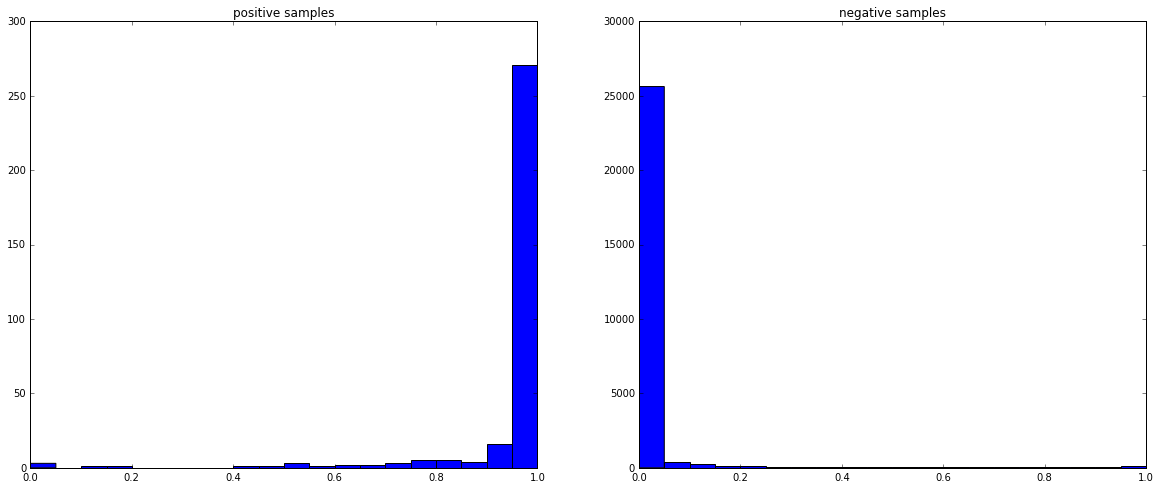

In [5]:
# check distribution probabilities
probs_pos = [] # <---- fill in this list!
probs_neg = [] # <---- fill in this list!

# collect probabilities for positive samples
for filename in tra_pos_files[1]:
    probs_pos.append((float(filename.split('_')[0]), filename))
    
# collect probabilities for negative samples
for filename in tra_neg_files[1]:
    probs_neg.append((float(filename.split('_')[0]), filename))
    
# visualize histograms
plt.subplot(1,2,1)
plt.hist([x[0] for x in probs_pos], 20); plt.title('positive samples')
plt.subplot(1,2,2)
plt.hist([x[0] for x in probs_neg], 20); plt.title('negative samples')
plt.show()

As you can see, most of the positive samples have already a high score, but some of them also have a very low score, given by the first network. On the other hand, most of the negative samples have a low score (mostly background patches), but few of those have a high score (likely black dots in the tile). We should therefore focus on the positive that are not well classified, and the negative that are classified as mitosis!

To better understand this phenomenon, let's visualize 10 patches of positive cases with the lowest probability (we could call it *unusual positives*), and 10 patches of negative cases with the  highest probability (we could call it *hard negative*).

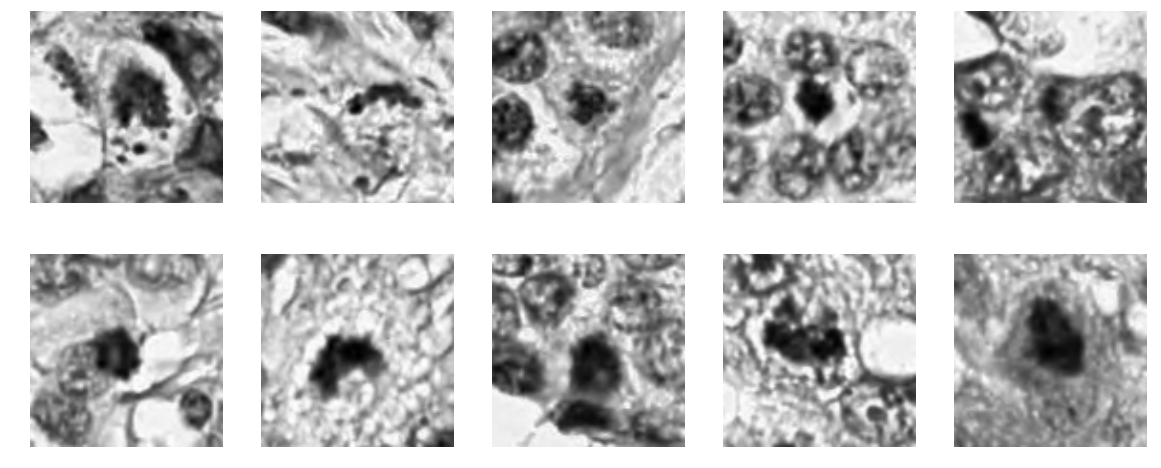

In [6]:
# visualize the first 10 positive cases with low probability
pos_cases = sorted(probs_pos, key=lambda x: x[0])[:10]
for i in range(10):
    img = np.asarray(Image.open(os.path.join(data_dir, 'training', 'positive', pos_cases[i][1])))
    plt.subplot(2,5,i+1)
    plt.axis('off')
    plt.imshow(img[:,:,0], cmap='gray')

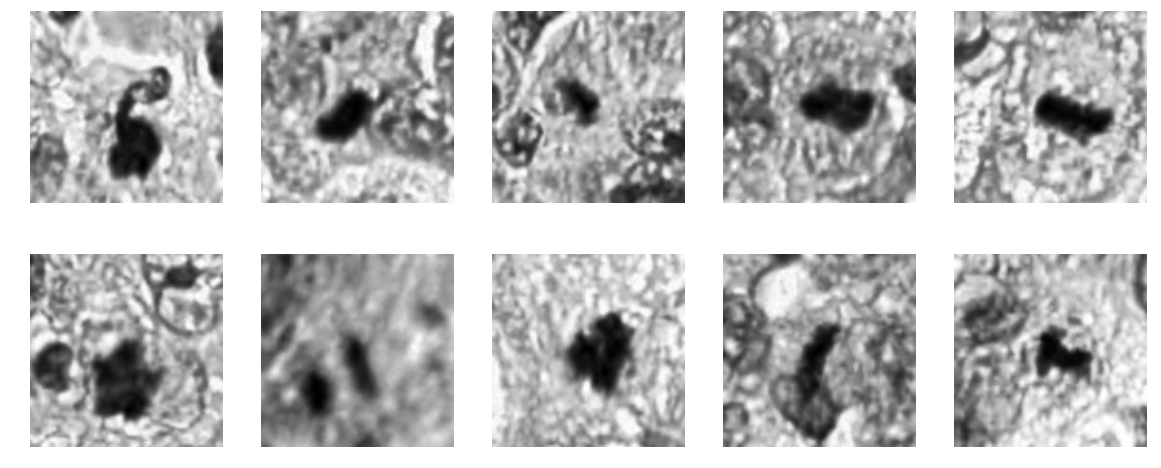

In [7]:
# visualize the first 10 negative cases with high probability
high_prob_neg_cases = []
for case in probs_neg:
    if case[0] > 0.8:
        high_prob_neg_cases.append(case)
        
neg_cases = sorted(high_prob_neg_cases, key=lambda x: x[0], reverse=True)[:10]
for i in range(10):
    img = np.asarray(Image.open(os.path.join(data_dir, 'training', 'negative', neg_cases[i][1])))
    plt.subplot(2,5,i+1)
    plt.axis('off')
    plt.imshow(img[:,:,0], cmap='gray')

Now that you have loaded the training set and understood a bit better the problem, you can start building you system.
As we said, you will have quite some freedom in this last assignment, we provided all the tools necessary to build convolutional networks and you have acquired exprecience already.
Therefore, in the rest of the notebook, we will only guide you by mentioning the main steps you will have to implement, and some hints how to best do it for this specific application.

## Split training and validation set

We deinfe a convenience function that counts positive and negative samples given a split.

In [18]:
def count_pos_neg(tra_pos_files, tra_neg_files, train_idxs, val_idxs):
    '''Count positive and negatives given this split.'''
    n_pos_tra = 0; fls_pos_tra = []
    n_neg_tra = 0; fls_neg_tra = []
    n_pos_val = 0; fls_pos_val = []
    n_neg_val = 0; fls_neg_val = []

    all_files = tra_pos_files[0] + tra_neg_files[0]
    for f in range(len(all_files)):
        elems = ntpath.basename(all_files[f]).split('_')
        idx = elems[1]
        label = elems[6][:-4]
        if idx in train_idxs:
            if label == '1':
                n_pos_tra += 1
                fls_pos_tra.append(all_files[f])
            else:
                n_neg_tra += 1
                fls_neg_tra.append(all_files[f])
        elif idx in val_idxs:
            if label == '1':
                n_pos_val += 1
                fls_pos_val.append(all_files[f])
            else:
                n_neg_val += 1
                fls_neg_val.append(all_files[f])
    return (n_pos_tra, n_neg_tra), (n_pos_val, n_neg_val), (fls_pos_tra, fls_neg_tra), (fls_pos_val, fls_neg_val)

In [9]:
# Lists of caseIDs used for training and validation. Example: train_idxs = ['01', '02', ...]
# Note that cases '01', '06', '10' and '11' are not part of the training set, since they are part of the test set.
# Check what is the ratio of samples between training and validation for both positive and negative

caseID =[]

# get all caseID's (all have negative patches, so we look in the negative stack)
for f in tra_neg_files[1]:
    caseID.append(f.split('_')[1])

# get unique IDs
caseID = np.unique(caseID).tolist()

# define val/train
val = int(np.ceil(len(caseID) * 0.3))
tra = len(caseID) - val

# shuffle them 
np.random.shuffle(caseID)

val_idxs = caseID[:val] 
train_idxs = caseID[val:] 

print caseID

n_tra, n_val, fls_tra, fls_val = count_pos_neg(tra_pos_files, tra_neg_files, train_idxs, val_idxs)

print('training: {} positive, {} negative'.format(n_tra[0], n_tra[1]))
print('validation: {} positive, {} negative'.format(n_val[0], n_val[1]))

['12', '08', '03', '09', '04', '05', '07', '02']
training: 292 positive, 21505 negative
validation: 27 positive, 5820 negative


## Compute distribution of probabilities in negative samples
In order to proarly sample *hard negative* during training, we need to take into account for the probability of each sample as classified by the first network.
The score is part of the filename of each patch, so it is easy to retrieve.
When you build your training set, remember that you may want to sample **more** from **hard negative** and **less** from **easy negatives**. This means that you want to sample a lot of negative patches with a high socre, and only few negative patches with a low score, because those will be easy samples to learn, and your network will not need a lot of those.
But it will need a lot of the difficult ones!

Numpy has a function that is convenient for this task:

        numpy.random.choice()
        
If you check the documentation of this function, you will see that it is possible to pass a parameter ```p``` that indicates the distribution of probability to use when randomly sampling.
If you pass the vector of scores of training patches, it will do the trick!
But first you have to build this vector, and remembr that the correspondence ```score-patch``` is important, so make sure tha the ```i-th``` socre corresponds to the ```i-th``` patch in your set!

In [10]:
from scipy.stats import norm
# compute the vector of probability (and the normalized one) from the training set
tra_p = []
for f in tra_neg_files[1]:
    if f.split('_')[1] in train_idxs:
        tra_p.append(float(f.split('_')[0]))
print 'training negative patches', len(tra_p)

tra_p_norm = np.array([i / sum(tra_p) for i in tra_p]).T


training negative patches 21505


Now we simulate sampling 40 mini-batches of 64 samples each and check what is the distribution of their scores per mini-batch.
We compare what happens if the distribution ```p_norm``` is considered or not during sampling.

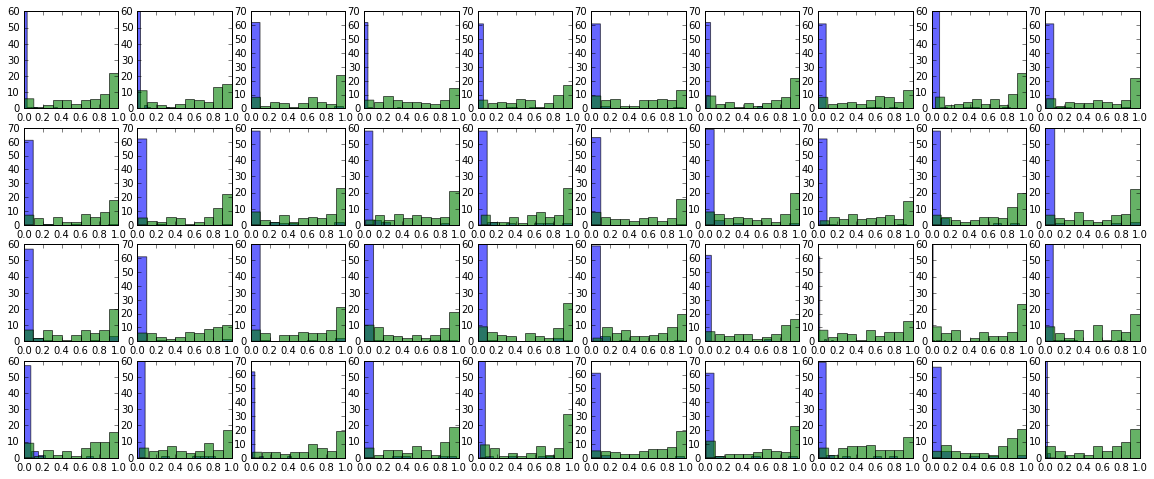

In [11]:
# Show histograms of scores per mini-batch

# sampling based on random selection
for n in range(40):
    tmp = np.random.choice(tra_p, size=64)
    plt.subplot(4, 10, n+1)
    plt.hist(tmp, alpha=0.6)

# sampling of a mini-batch based on distribution
for n in range(40):
    tmp = np.random.choice(tra_p, size=64, p=tra_p_norm)
    plt.subplot(4, 10, n+1)
    plt.hist(tmp, alpha=0.6)
plt.show()

## Next steps
Now we really give you the freedom to develop the rest of this assignment!
You will have to include the following parts (already seen in previous assignments):

        build_network()
        training_function()
        validate_function()
        evaluate_function()
        get_mini_batch()
        train_network()
        
You may consider implementing the ```get_mini_batch()``` function in such a way that random patches are sampled on the fly during training, and making mini-batches balanced, and using the 'trick' of focusing more on hard negative samples.

As we have larned from last week's assignment, it is also easy to include data augmentation on the fly! You can use any kind of data augmentation you can think of, consider that parameters like color, sharpness and blurring of the patch are only some of the things that vary across patches/images. Since the positive class is heavily underrepresented, you could consider augmenting it much more than the negative one.

Try to visualize the results you get in the validation set, patches correctly and wrongly classified, to get some understanding about what your network is learning. Try several architectures and parameters tuning.

**Note.** During training, you may want to evaluate the performance on the validation set. Since this set may contain a lot of negative samples, the evaluation could slow down the process a lot.
You may consider (1) reducing the negative samples of the validation set, (2) validating only every N epochs.

**Note.** At the end of this notebook, the evaluation cell will assume that the lasagne parameters of a network called ```mitosis_network``` have been saved (based on what we have done in previous assignments). If you prefer using another strategy for defining, loading, saving networks, adjust the first part of the last cell in this notebook accordingly, otherwise it should work out of the box.

## Data Augmentation 

In [30]:
from skimage.io import imread
from skimage.filters import gaussian
from skimage.transform import rotate
from scipy.ndimage import zoom

class MitosisCreator:

    def __init__(self, img_files=[], copies_per_image=1, random=False):
        self.imgs = img_files
        self.copies = copies_per_image -1
        self.random = random
        
    '''
        Data augmentation class.
        
            imgs_files = list of (strings) file paths
            
            copies_per_image = how many different copies of animage will be after. 
            The time of trasnformation is always chose at random.

            random = if to randomly create fake data or not. This implies that the output will AT MOST have 
            lenght len(img_files) * augment_per_image, i.e: 
                                    len(img_files) * copies_per_image > len(output)
        
    '''

    def set_imgs(self, imgs):
        self.imgs = imgs
        
    def blur(self, img, sigma):
        return gaussian(img, sigma=sigma, multichannel=True) 
    
    def fliph(self, img):
        return np.fliplr(img) 
        
    def flipv(self, img):
        return np.flipud(img) 
    
    def zoom_in(self, img, zoom_factor):

        h, w = img.shape[:2]

        # width and height of the zoomed image
        zh = int(np.round(zoom_factor * h))
        zw = int(np.round(zoom_factor * w))

        zoom_tuple = (zoom_factor,) * 2 + (1,) * (img.ndim - 2)

        # bounding box of the clip region within the input array
        top = (zh - h) // 2
        left = (zw - w) // 2
        out = zoom(img[top:top+zh, left:left+zw], zoom_tuple)

        # trim off any extra pixels at the edges
        trim_top = ((out.shape[0] - h) // 2)
        trim_left = ((out.shape[1] - w) // 2)
        
        return out[trim_top:trim_top+h, trim_left:trim_left+w]
    
    def rotateX(self, img, max_rotation):
        angle = np.random.uniform(-max_rotation, max_rotation)
        rot = rotate(img, angle)
#         rot = self.zoom_in(rot, zoom_factor=1.2)
        return rot

    def apply_fun(self, img, fun):
        
        if fun == 'blur':
            sigma = np.random.rand() * 1.4 + 0.1
            new_img = self.blur(img, sigma)
        elif fun == 'rotate':
            new_img = self.rotateX(img, 45)
        elif fun == 'fliph':
            new_img = self.fliph(img)
        elif fun == 'flipv':
            new_img = self.flipv(img)
        elif fun == 'zoom':
            zoom = np.random.choice(np.arange(1.2,1.4,0.1))
            new_img = self.zoom_in(img, zoom)
        
        return new_img 
        

    def run(self):
        
        assert self.imgs, 'list of images is empty' 
        assert self.copies > 0, 'why would you use this if you wanted 0 new pictures from this image set?'
        
        transform = ['blur', 'rotate', 'fliph', 'flipv', 'zoom']
        
        new_img = []
        for f in self.imgs:
            
#             img = imread(f)[:,:,:1] # red channel
            img = imread(f)
            
            for _ in range(self.copies):
                
                fun = np.random.choice(transform)
                
                if self.random:
                    
                    if np.random.rand() > 0.5:
                        new_img.append(self.apply_fun(img, fun) / 255.)
                    else:
                        continue
                else: 
                     new_img.append(self.apply_fun(img, fun) / 255.)
                    
        
        if len(new_img) > 1:
            return np.stack(new_img)
        else:
            return np.array(new_img)

## Testing data augmentation

fliph
fliph
blur
(3, 101, 101, 3)
shape (101, 101, 3)


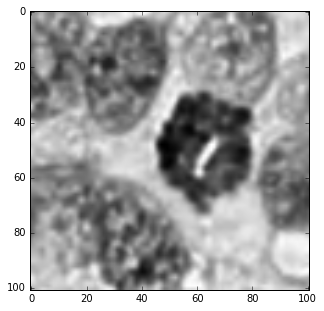

shape (101, 101, 3)


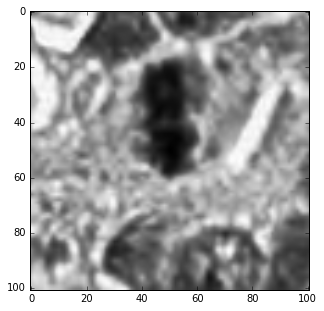

shape (101, 101, 3)


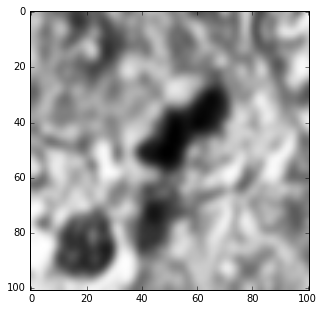

In [25]:
c = 3 # originals
n = 2 # duplicates

testing = tra_pos_files[0][:c]
mit = MitosisCreator(testing, copies_per_image=2, random=False)
out = mit.run()
print out.shape


# fig, ax = plt.subplots(3, 3)
# ax = ax.ravel()
# for i, f in enumerate(testing):
#     ii = i * c
#     iii = i * n
#     ax[ii].imshow(imread(f))
#     ax[ii+1].imshow(out[iii])
#     ax[ii+2].imshow(out[iii+1])
    
#     n += 1
# plt.show()

for i in out:
    print 'shape', i.shape
    plt.figure(figsize=(5,5))
    plt.imshow(i[:,:,0], cmap='gray')
#     plt.imshow(i)
    plt.show()
    
# for i in testing:
#     plt.figure(figsize=(5,5))
#     img = imread(i)
#     plt.imshow(img)
#     plt.show()


## Batch extractor 

In [26]:
from sklearn.utils import shuffle

class BatchExtractor:

    def __init__(self, tra_pos_files, tra_neg_files, case_id, batch_size, augmentator=None, neg_ratio=0.66):
        
        self.tra_pos_files = tra_pos_files
        self.tra_neg_files = tra_neg_files
        self.case_id = case_id
        self.batch_size = batch_size
        self.augmentator = augmentator
        self.neg_ratio = neg_ratio
    
    def get_pos_files(self):       
        pos = []
        for f in self.tra_pos_files[0]:
            if f.split('/')[-1].split('_')[1] in self.case_id:
                pos.append(f)
        
        self.pos = shuffle(pos)
        
    def get_neg_files(self):
        neg, neg_p = [], []
        for f in self.tra_neg_files[0]:
            if f.split('/')[-1].split('_')[1] in self.case_id:
                neg.append(f)
                neg_p.append(float(f.split('/')[-1].split('_')[0]))

        self.neg = shuffle(neg)
        self.p_norm_neg = [i / sum(neg_p) for i in neg_p]
        
    def get_ratios(self):
        
        num_neg = int(np.floor(self.batch_size * np.random.rand()))
        
        if self.neg_ratio:
            num_neg = int(np.floor(self.batch_size * self.neg_ratio))  
        
        num_pos = self.batch_size - num_neg
        if self.augmentator is not None:
            if num_pos > self.augmentator.copies:
                num_pos = int(np.floor(float(num_pos) / (self.augmentator.copies + 1)))
            else:
                raise Exception('Need larger batch size with data augmentation')
                
        return num_pos, num_neg

    def read_imgs(self, imgs):
        images = []
        for img in imgs:
            images.append(imread(img) / 255.)
#             images.append(imread(img)[:,:,:1] / 255.) # red channel
        return np.array(images)
    
    def start(self):
        
        self.get_pos_files()
        self.get_neg_files()
        
        # set the porportions depending on neg_ratio and if there is data augmentation
        return self.get_ratios()
    
    def get_mini_batch(self, b, num_pos, num_neg):
              
        # get files for the batch
        positives = self.pos[b*num_pos: b*num_pos+num_pos]
        negatives = np.random.choice(self.neg, size=num_neg, p=self.p_norm_neg).tolist()
        
        # read and store them
        X_batch_pos = self.read_imgs(positives)
        X_batch_neg = self.read_imgs(negatives)
        
        
        # if data augmentation, then add the newly created images
        if self.augmentator is not None:
            self.augmentator.set_imgs(positives)
            X_batch_pos_aug = self.augmentator.run()
            X_batch_pos = np.concatenate([X_batch_pos, X_batch_pos_aug], axis=0)
            
        # create labels
        Y_batch_pos = np.ones([len(X_batch_pos)])
        Y_batch_neg = np.zeros([len(X_batch_neg)])
        
        # concat them
        X_batch = np.concatenate([X_batch_pos, X_batch_neg], axis=0)
        Y_batch = np.concatenate([Y_batch_pos, Y_batch_neg], axis=0)
        
        # shuffle them
        X_batch, Y_batch = shuffle(X_batch, Y_batch)

        return np.array(X_batch).swapaxes(1,3), np.array(Y_batch) 

## Split train/val sets

In [27]:
def split(tra_pos_files, tra_neg_files, ratio):
    
    caseID =[]
    # get all caseID's (all have negative patches, so we look in the negative stack)
    for f in tra_neg_files[1]:
        caseID.append(f.split('_')[1])

    # get unique IDs
    caseID = np.unique(caseID).tolist()

    # define val/train
    val = int(np.ceil(len(caseID) * ratio))
    tra = len(caseID) - val

    # shuffle them 
    np.random.shuffle(caseID)

    val_idxs = caseID[:val] 
    train_idxs = caseID[val:] 

    n_tra, n_val, fls_tra, fls_val = count_pos_neg(tra_pos_files, tra_neg_files, train_idxs, val_idxs)

    print('training: {} positive, {} negative'.format(n_tra[0], n_tra[1]))
    print('validation: {} positive, {} negative'.format(n_val[0], n_val[1]))
    
    return train_idxs, val_idxs, n_tra, n_val


## Testing batch iterator

In [28]:
train_ids, val_ids, _, _ = split(tra_pos_files, tra_neg_files, 0.3)
print train_ids, val_ids

data_augm = MitosisCreator(copies_per_image=2, random=False)
batcher = BatchExtractor(tra_pos_files,
                         tra_neg_files,
                         val_ids,
                         augmentator=data_augm,
                         batch_size=64)
n_pos, n_neg = batcher.start()
print n_pos, n_neg

training: 292 positive, 21505 negative
validation: 27 positive, 5820 negative
['02', '05', '04', '09', '07'] ['03', '08', '12']
11 42


In [29]:
# batch size os only variable (< batch_size) if MitosisCreator(random=True)
x_batch, y_batch = batcher.get_mini_batch(1, n_pos, n_neg)
x_batch.shape

blur
zoom
zoom
flipv
flipv
rotate
zoom
zoom
fliph
zoom
zoom


(64, 3, 101, 101)

## Build network

In [37]:
import lasagne.layers as L

# Define your network builder function. 

def build_network(input_tensor, input_size):
    # define the inputlayer
    network = L.InputLayer(shape=(None, input_size[0], input_size[1], input_size[2]), input_var = input_tensor)
    
    network = L.DropoutLayer(network, p=0.15)
     
    network = L.Conv2DLayer(network, 
                            num_filters=32, 
                            filter_size=(3, 3),
                            nonlinearity=lasagne.nonlinearities.rectify)
    
    network = L.Conv2DLayer(network, 
                            num_filters=32, 
                            filter_size=(3, 3),
                            nonlinearity=lasagne.nonlinearities.rectify)
    
    network = L.MaxPool2DLayer(network, pool_size=(2, 2))
    
    network = L.Conv2DLayer(network, 
                            num_filters=64, 
                            filter_size=(3, 3),
                            nonlinearity=lasagne.nonlinearities.rectify)
    
    network = L.Conv2DLayer(network, 
                            num_filters=64, 
                            filter_size=(3, 3),
                            nonlinearity=lasagne.nonlinearities.rectify)
    
    network = L.Conv2DLayer(network, 
                            num_filters=64, 
                            filter_size=(5, 5),
                            nonlinearity=lasagne.nonlinearities.rectify)
    
    network = L.DropoutLayer(network, p=0.25)
    
    network = L.MaxPool2DLayer(network, pool_size=(2, 2))
    
    network = L.Conv2DLayer(network, 
                            num_filters=128, 
                            filter_size=(3, 3),
                            nonlinearity=lasagne.nonlinearities.rectify)

    network = L.Conv2DLayer(network, 
                            num_filters=64, 
                            filter_size=(3, 3),
                            nonlinearity=lasagne.nonlinearities.rectify)
    # 16x16 till here
    network = L.DenseLayer(network, 
                           num_units=32)
    
    network = L.DropoutLayer(network, p=0.25)
    
    network = L.DenseLayer(network, 
                           num_units=2,
                           nonlinearity=lasagne.nonlinearities.softmax)
                         
    return network


## Training, Validation and Evaluation functions

In [48]:
def training_function(network, input_tensor, target_tensor, learning_rate, use_l2_regularization=False):

    network_output = L.get_output(network)
    
    if use_l2_regularization:
        l2_loss = lasagne.regularization.regularize_network_params(network, lasagne.regularization.l2)
        loss = lasagne.objectives.categorical_crossentropy(network_output, target_tensor).mean() + (l2_loss * 0.0001)
    else:
        loss = lasagne.objectives.categorical_crossentropy(network_output, target_tensor).mean()
        
    accuracy = T.mean(T.eq(T.argmax(network_output, axis=1), target_tensor), dtype=theano.config.floatX)
    
    # Get the network parameters and the update function.
    network_params  = L.get_all_params(network, trainable=True)
    weight_updates  = lasagne.updates.adam(loss, network_params, learning_rate)

    # Construct the training function.
    return theano.function([input_tensor, target_tensor], [loss, accuracy], updates=weight_updates)


def validate_function(network, input_tensor, target_tensor):

    # Get the network output and calculate metrics.
    network_output = L.get_output(network, deterministic=True)
    loss = lasagne.objectives.categorical_crossentropy(network_output, target_tensor).mean() 
#     accuracy = T.mean(T.eq(T.argmax(network_output, axis=1), target_tensor), dtype=theano.config.floatX)
    pred = T.argmax(network_output, axis=1)
    
    # Construct the validation function.
    return theano.function([input_tensor, target_tensor], [loss, pred])


def evaluate_function(network, input_tensor):
 
    # Get the network output and calculate metrics.
    network_output = lasagne.layers.get_output(network, deterministic=True)
    
    # Construct the evaluation function.
    return theano.function([input_tensor], network_output)

## Parameters

In [49]:
patch_size = (3,101,101)
nr_epochs = 10
validation_batch_size = 8
batch_size = 64
learning_rate = .0001
network_name = 'baseline'

copies = 8
validation_ratio = 0.2
negative_ratio = 0.8


## Compile functions

In [50]:
inputs = T.ftensor4('X') 
targets = T.ivector('Y')

network = build_network(inputs, patch_size)

train_fn = training_function(network=network, input_tensor=inputs, target_tensor=targets, learning_rate=learning_rate,
                             use_l2_regularization=True)
validation_fn = validate_function(network=network, input_tensor=inputs, target_tensor=targets)
evaluation_fn = evaluate_function(network=network, input_tensor=inputs)

## Training loop

In [ ]:
from sklearn.metrics import f1_score
train_ids, val_ids, n_tra, n_val = split(tra_pos_files, tra_neg_files, validation_ratio)

best_val_acc = 0.0
tra_loss_lst = []
tra_acc_lst = []
val_loss_lst = []
val_acc_lst = []  

# Main training loop
for epoch in range(nr_epochs):
    print('Epoch {}'.format(epoch+1))
    
    # training
    data_augm = MitosisCreator(copies_per_image=copies)
    train_batcher = BatchExtractor(tra_pos_files,
                                   tra_neg_files,
                                   train_ids,
                                   augmentator=data_augm,
                                   batch_size=batch_size, 
                                   neg_ratio=negative_ratio)
    
    tra_pos, tra_neg = train_batcher.start()
    nr_train_batches = int(np.floor(n_tra[0] / tra_pos))
    
    tra_losses = []
    tra_accs = []
    print('training...')
    for b in tqdm_notebook(range(0, nr_train_batches), leave=False):
        X, Y = x_batch, y_batch = train_batcher.get_mini_batch(b, tra_pos, tra_neg)    
        loss, accuracy = train_fn(X.astype(np.float32), Y.astype(np.int32))
        tra_losses.append(loss)
        tra_accs.append(accuracy)
    tra_loss_lst.append(np.mean(tra_losses))
    tra_acc_lst.append(np.mean(tra_accs))
        
    
    # validation
    val_batcher = BatchExtractor(tra_pos_files,
                                 tra_neg_files,
                                 val_ids,
                                 batch_size=validation_batch_size, 
                                 neg_ratio=negative_ratio)
                                
    val_pos, val_neg = val_batcher.start()
    nr_val_batches = int(np.floor(n_val[0] / val_pos))
    
    val_losses = []
    val_accs = []
    val_preds, val_targs = [], []
    f1 = 0.0
    print('validation...')
    for b in tqdm_notebook(range(0, nr_val_batches), leave=False):
        X, Y = x_batch, y_batch = val_batcher.get_mini_batch(b, val_pos, val_neg)
        loss, pred = validation_fn(X.astype(np.float32), Y.astype(np.int32))
        val_losses.append(loss)
        val_preds.append(pred)
        val_targs.append(Y)
        
    val_preds = np.hstack(val_preds)
    val_targs = np.hstack(val_targs)
    f1 = f1_score(val_preds, val_targs)  
        
        
    val_loss_lst.append(np.mean(val_losses))
    val_acc_lst.append(f1)   

    #continue
    if f1 > best_val_acc:
        best_val_acc = f1
        # save network
        params = L.get_all_param_values(network)
        np.savez(os.path.join('./', network_name+'.npz'), params=params)

    # plot learning curves
    fig = plt.figure(figsize=(10, 5))
    tra_loss_plt, = plt.plot(range(len(tra_loss_lst)), tra_loss_lst, 'b')
    val_loss_plt, = plt.plot(range(len(val_loss_lst)), val_loss_lst, 'g')
    tra_acc_plt, = plt.plot(range(len(tra_acc_lst)), tra_acc_lst, 'm')
    val_acc_plt, = plt.plot(range(len(val_acc_lst)), val_acc_lst, 'r')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend([tra_loss_plt, val_loss_plt, tra_acc_plt, val_acc_plt], 
                ['training loss', 'validation loss', 'training accuracy', 'validation accuracy'],
                loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title('Best validation accuracy = {:.2f}%'.format(100. * f1))
    display.clear_output(wait=True)
    display.display(plt.gcf())
    time.sleep(.2)

training: 125 positive, 18007 negative
validation: 194 positive, 9318 negative
Epoch 1
training...


## Test and submit to challengr

In [53]:
# initialize the network used in this experiment (this may change)
network = build_network(inputs, patch_size)
npz = np.load(os.path.join('./', network_name+'.npz')) # load stored parameters
L.set_all_param_values(network, npz['params']) # set parameters

# make csv file with classification results on the test set
test_fls = get_file_list(os.path.join(data_dir, 'test'), 'png')
ho = open('./test_results.csv', 'w')
ho.write('file_id,label\n')
for f in tqdm_notebook(range(len(test_fls[0]))):
    patch = np.asarray(Image.open(test_fls[0][f])).transpose(2, 0, 1)[np.newaxis,:]
#     patch = patch[:,:1,:,:]
    #.reshape(1, patch_size[2], patch_size[0], patch_size[1])
    pred = evaluation_fn((patch/255.).astype('float32'))
    y = np.argmax(pred[0])
    ho.write('{},{}\n'.format(test_fls[1][f][:-4], y))
ho.close()

In [54]:
# submit to challengr
import challenger

challenger.submit_results({'username': 'n.alfonsoburgos',
                           'password': 'XJE4PYVP'},
                          "./test_results.csv",
                          {'notes': 'im gonna have cocktails now'})

Validating the csv file
Creating /tmp/tmpEklaFV/challengr.json
Compressing results
Uploading results to server
Done. The results of your submission will appear shortly on the leaderboard at http://ismi17.diagnijmegen.nl/


# Submission
Document all your experiments, add new cells to this notebook if necessary.
Submit the notebook fully executed to Peter (peter.bandi@radboudumc.nl) and Gabriel (g.humpiremamani@radboudumc.nl). 